In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cut_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import SpectralClustering

<h3>Task 2</h3>

In [2]:
sportsranks = pd.read_csv('/Users/herrakaava/Documents/school/monimuuttujamenetelmat/week_5/sportsranks.csv', index_col=0)

**Description**

Louis Roussos asked n = 130 people to rank seven sports, assigning #1 to the sport they most wish to participate in, and #7 to the one they least wish to participate in. The sports are baseball, football, basketball, tennis, cycling, swimming and jogging.

In [3]:
sportsranks.reset_index(drop=True, inplace=True)

In [4]:
sportsranks.head()

,Baseball,Football,Basketball,Tennis,Cycling,Swimming,Jogging
0,1,3,7,2,4,5,6
1,1,3,2,5,4,7,6
2,1,3,2,5,4,7,6
3,4,7,3,1,5,6,2
4,2,3,1,7,6,5,4


In [5]:
sportsranks.shape

(130, 7)

In [6]:
sportsranks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Baseball    130 non-null    int64
 1   Football    130 non-null    int64
 2   Basketball  130 non-null    int64
 3   Tennis      130 non-null    int64
 4   Cycling     130 non-null    int64
 5   Swimming    130 non-null    int64
 6   Jogging     130 non-null    int64
dtypes: int64(7)
memory usage: 7.2 KB


In [7]:
sportsranks.isna().any()

Baseball      False
Football      False
Basketball    False
Tennis        False
Cycling       False
Swimming      False
Jogging       False
dtype: bool

In [54]:
def find_optimal_num_clust(data, K, data_label=None):
    """
    Finds the optimal number of clusters in K-means using the elbow method.
    """
    ##### Fitting #####
    RSS = []
    for k in range(1, K+1):
        km = KMeans(n_clusters=k, random_state=1)
        km.fit(data)
        RSS.append(km.inertia_)
        
    ##### Plotting #####
    plt.figure(figsize=(8,6), dpi=100)
    plt.plot(np.arange(1,K+1), RSS, color='black')
    plt.scatter(np.arange(1,K+1), RSS, facecolors='none', edgecolors='black', s=50)
    plt.xlabel('Number of clusters', size=12, labelpad=12)
    plt.ylabel('RSS (inertia)', labelpad=12);
    
    if data_label:
        plt.title(f'Elbow plot for {data_label}')

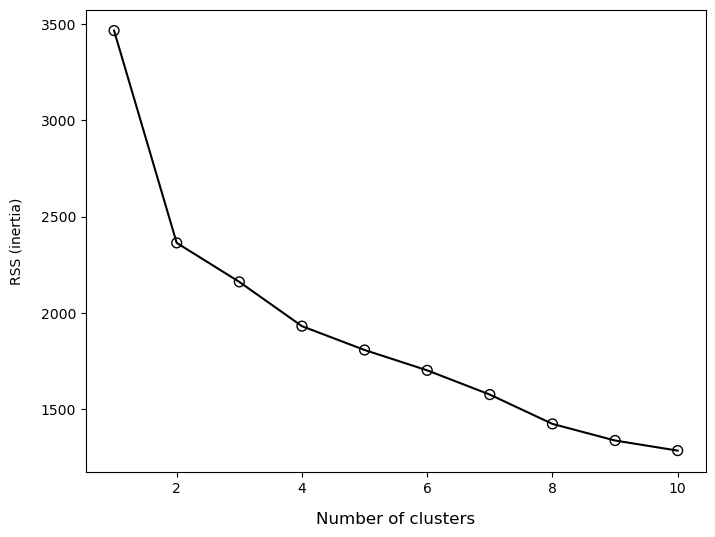

In [9]:
find_optimal_num_clust(data=sportsranks, K=10)

- As can be seen, the "elbow" is steepest at $\, \text{k}=2.$ 

$\, \quad \, \, \boldsymbol{\rightarrow} \,$ choose $\, \text{k}=2 \,$ to be the number of clusters.

In [15]:
def fit_kmeans(data, k, rs=None):
    km = KMeans(n_clusters=k, random_state=rs)
    km.fit(data)
    return km

In [11]:
fit1 = fit_kmeans(data=sportsranks, k=2, rs=1)

In [12]:
fit1.cluster_centers_.shape

(2, 7)

- The rows represent the centroids (cluster centers) of the two clusters discovered by the K-means algorithm.

In [13]:
def visualize_centroids(fit, col_names):
    centroids = np.round(fit.cluster_centers_, 3)
    df = pd.DataFrame({
        'Avg_val_clust_1': centroids[0],
        'Avg_val_clust_2': centroids[1]
    })
    df.index = col_names
    return df

In [14]:
visualize_centroids(fit1, list(sportsranks.columns))

,Avg_val_clust_1,Avg_val_clust_2
Baseball,5.015,2.452
Football,5.838,2.597
Basketball,4.353,3.065
Tennis,3.632,4.113
Cycling,2.574,4.710
Swimming,2.471,5.210
Jogging,4.118,5.855


- These values represent the average ranks given by the people in each cluster for each sport.
- For example, for all the points assigned to the first cluster, the average value for **Baseball** is approx. 5.01.
- Given that an observation (i.e., a person) is assigned to the first cluster, they typically rank **Baseball** as their fifth favorite sport (among the given options).

In [15]:
def plot_hist(fit, data):
    """
    Notes:
    - w_i could be simply calculated with: data.dot(z)
    """
    # Predict the clusters based on the training data
    # (assign each observation (row) in the data into one of the two clusters)
    # (clusters[i] = 0 --> observation i assigned to the 1st cluster)
    # (clusters[i] = 1 --> observation i assigned to the 2nd cluster)
    clusters = fit.predict(data)
    
    ##### Calculations #####
    mu_hat_1, mu_hat_2 = fit.cluster_centers_
    z = (mu_hat_2 - mu_hat_1) / np.linalg.norm(mu_hat_2 - mu_hat_1)
    w = np.array([z.T @ x[:, np.newaxis] for x in data.values])
    
    ##### Plotting #####
    plt.figure(figsize=(8,6), dpi=100)
    
    # The projections of the observations x_i that were assigned to cluster 1
    plt.hist(w[clusters == 0], bins=15, edgecolor='black', color='blue', alpha=0.7, label='Cluster uno', zorder=2)
    
    # The projections of the observations x_i that were assigned to cluster 2
    plt.hist(w[clusters == 1], bins=15, edgecolor='black', color='green', alpha=0.7, label='Cluster dos', zorder=3)
    
    plt.xlabel('Projection (w_i)', size=12)
    plt.ylabel('Freq', size=12)
    plt.title('Histogram of projections')
    plt.grid(True, alpha=0.4, zorder=1)
    plt.legend(bbox_to_anchor=(1,0.7), loc='upper left');

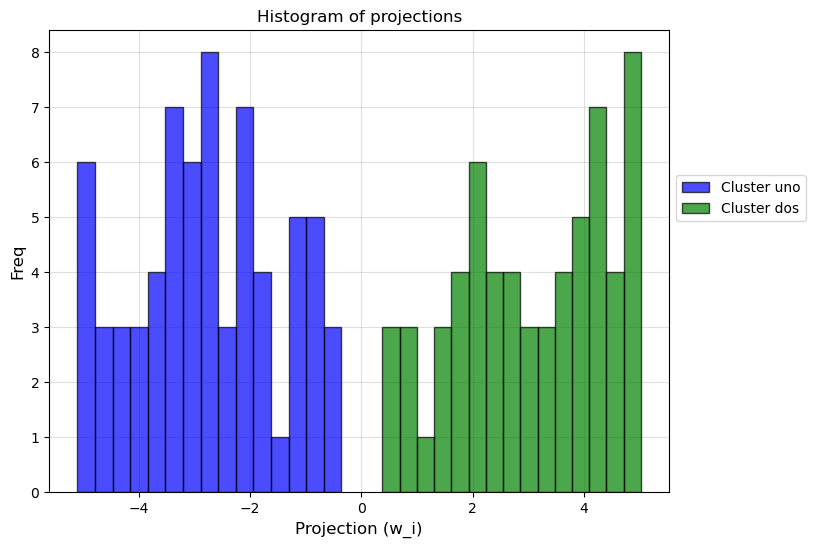

In [16]:
plot_hist(fit1, sportsranks)

<h3>Task 3</h3>

In [2]:
def gen_X():
    X1 = np.column_stack([np.random.normal(loc=0, scale=1, size=40), 
                          np.random.normal(loc=0, scale=1, size=40)])
    X2 = np.column_stack([np.random.normal(loc=8, scale=1, size=40), 
                          np.random.normal(loc=8, scale=1, size=40)])
    X3 = np.column_stack([np.arange(start=0, stop=8+0.4, step=0.4), 
                          np.arange(start=0, stop=8+0.4, step=0.4)])
    X = np.vstack([X1, X2, X3])
    
    plt.figure(figsize=(8,6), dpi=100)
    plt.gca().set_aspect(aspect='equal', adjustable='box')    # Set aspect ratio to 1:1
    plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='black')
    
    return X

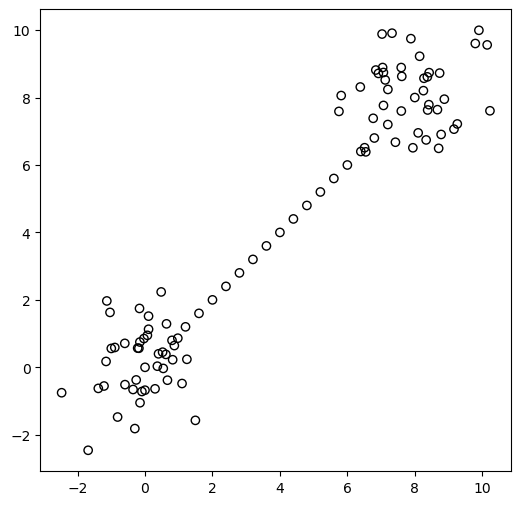

In [3]:
X = gen_X()

In [4]:
def gen_Y(n, rs=None):
    rng = np.random.default_rng(seed=rs)
    phi1 = rng.uniform(low=0, high=2*np.pi, size=n//2)
    r1 = rng.uniform(low=4, high=5, size=n//2)
    Y1 = np.column_stack([r1 * np.cos(phi1), r1 * np.sin(phi1)])
    phi2 = rng.uniform(low=0, high=2*np.pi, size=n//2)
    r2 = rng.uniform(low=1, high=2, size=n//2)
    Y2 = np.column_stack([r2 * np.cos(phi2), r2 * np.sin(phi2)])
    Y = np.vstack([Y1, Y2])
    
    plt.figure(figsize=(8,6), dpi=100)
    plt.gca().set_aspect(aspect='equal', adjustable='box')
    plt.scatter(Y[:, 0], Y[:, 1], facecolors='none', edgecolors='black')
    
    return Y

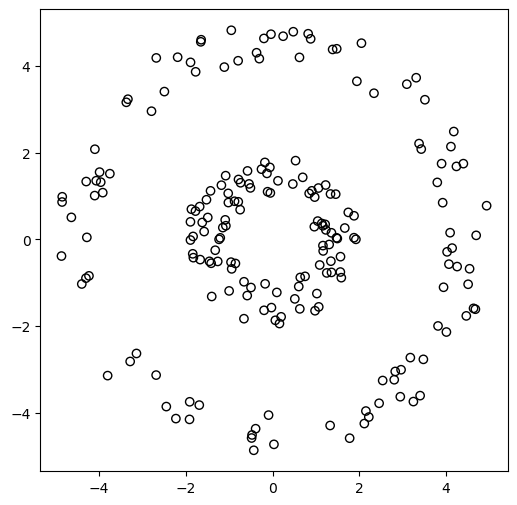

In [5]:
Y = gen_Y(n=200, rs=1234)

<br>

Let's explore the applicability of different clustering methods for grouping **X** and **Y** into two clusters.

<h3>K-means</h3>

In [49]:
km_X = fit_kmeans(data=X, k=2)
km_Y = fit_kmeans(data=Y, k=2)

In [50]:
km_X.cluster_centers_

array([[0.41752133, 0.52368884],
       [7.47944246, 7.52538047]])

In [51]:
km_Y.cluster_centers_

array([[ 1.77169225, -1.03780674],
       [-1.50546644,  1.43114534]])

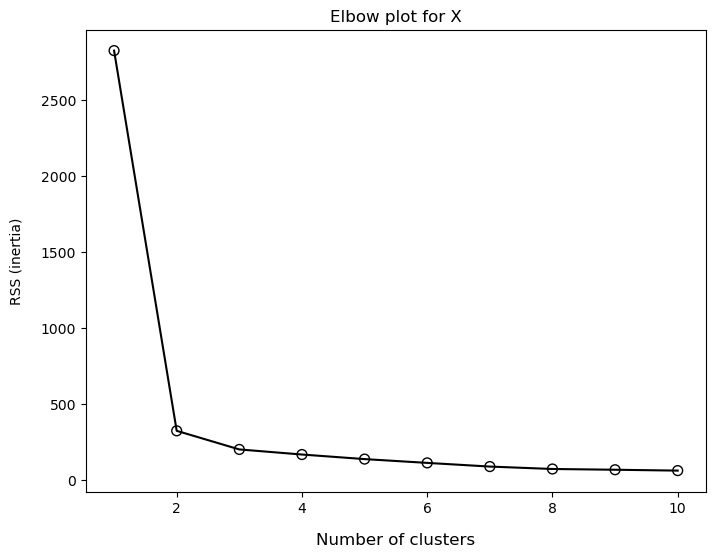

In [55]:
find_optimal_num_clust(X, K=10, data_label='X')

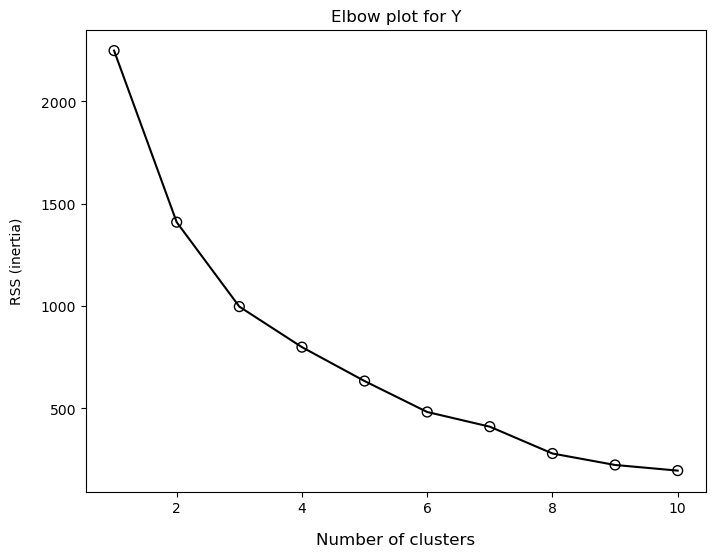

In [56]:
find_optimal_num_clust(Y, K=10, data_label='Y')

In [97]:
def eval_kmeans(data, k, data_label=None, rs=None):
    """
    Evaluates the applicability of K-means for the given data using sklearn's silhouette_score. 
    From the documentation of silhouette_score:
    
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indicate that a sample has
    been assigned to the wrong cluster, as a different cluster is more similar.
    """
    km = KMeans(n_clusters=k, random_state=rs)
    km.fit(data)
    cluster_preds = km.predict(data)
    score = silhouette_score(X=data, labels=cluster_preds, metric='euclidean')
    print(f'Silhouette score (k={k}) for {data_label}: {np.round(score, 3)}')

- [Silhouette (clustering)](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [117]:
for i in range(2, 8):
    eval_kmeans(X, k=i, data_label='X')

Silhouette score (k=2) for X: 0.766
Silhouette score (k=3) for X: 0.644
Silhouette score (k=4) for X: 0.477
Silhouette score (k=5) for X: 0.33
Silhouette score (k=6) for X: 0.361
Silhouette score (k=7) for X: 0.344


In [116]:
for i in range(2, 8):
    eval_kmeans(Y, k=i, data_label='Y')

Silhouette score (k=2) for Y: 0.342
Silhouette score (k=3) for Y: 0.346
Silhouette score (k=4) for Y: 0.33
Silhouette score (k=5) for Y: 0.385
Silhouette score (k=6) for Y: 0.425
Silhouette score (k=7) for Y: 0.473


In [128]:
def plot_clusters(data, k, rs=None, data_label=None):
    ##### Fitting #####
    km = KMeans(n_clusters=k, random_state=rs)
    km.fit(data)
    cluster_preds = km.predict(data)
    
    ##### Plotting #####
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(data[:, 0], data[:, 1], c=cluster_preds, edgecolors='black')
    plt.gca().set_aspect(aspect='equal', adjustable='box')
    plt.title(f'K-means with {k} clusters for {data_label}')

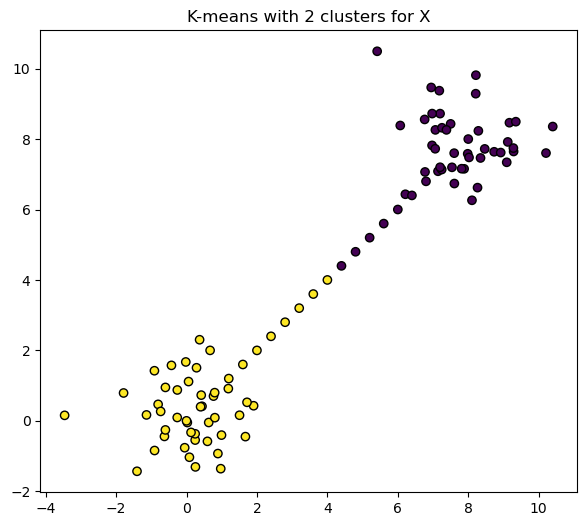

In [129]:
plot_clusters(X, k=2, data_label='X')

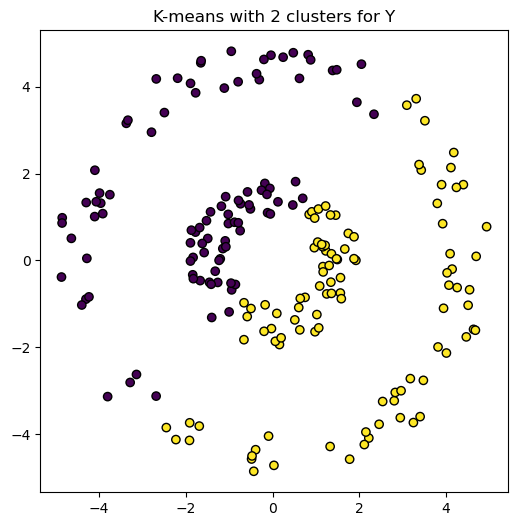

In [130]:
plot_clusters(Y, k=2, data_label='Y')

<h3>Hierarchical clustering</h3>

In [27]:
def hierarchical_clustering(data, distance_metric, linkage_method, num_clusters=None, data_label=None):
    # Calculate the pairwise distances between the rows
    D = pdist(data, metric=distance_metric)
    
    # Perform hierarchical clustering
    hc = linkage(D, method=linkage_method)
    
    # Cut the dendogram to form clusters
    # for 100 rows (data points), an array of length 100 is returned,
    # where the index i indicates to which group (cluster) the ith row belongs to
    cut_hc = cut_tree(hc, n_clusters=num_clusters).ravel()
    
    ##### Plotting #####
    plt.figure(figsize=(8,6), dpi=100)
    #dndogram = dendrogram(Z=hc)
    clusters = fcluster(Z=hc, t=num_clusters, criterion='maxclust')
    plt.scatter(data[:, 0], data[:, 1], c=clusters, edgecolors='black')
    plt.title(f'Hierarchical clustering with {distance_metric} distance and {linkage_method} linkage for {data_label}')
    plt.gca().set_aspect('equal', adjustable='box')

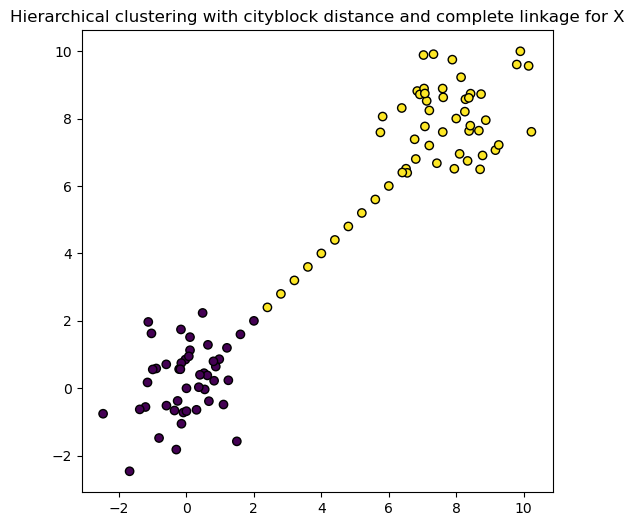

In [28]:
hierarchical_clustering(data=X,
                        distance_metric='cityblock',
                        linkage_method='complete',
                        num_clusters=2,
                        data_label='X')

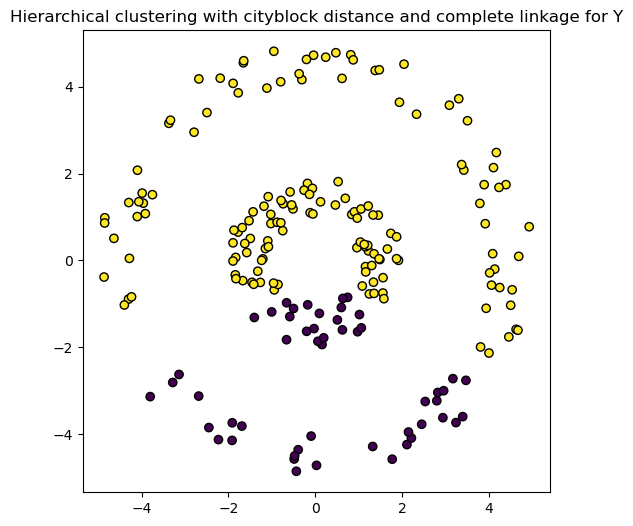

In [29]:
hierarchical_clustering(data=Y,
                        distance_metric='cityblock',
                        linkage_method='complete',
                        num_clusters=2,
                        data_label='Y')

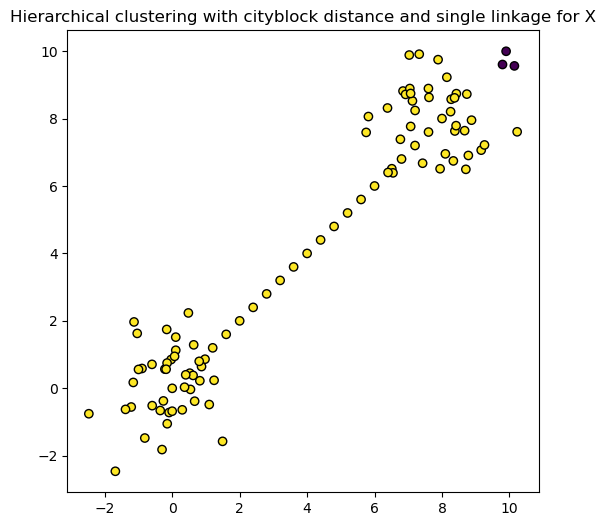

In [30]:
hierarchical_clustering(data=X,
                        distance_metric='cityblock',
                        linkage_method='single',
                        num_clusters=2,
                        data_label='X')

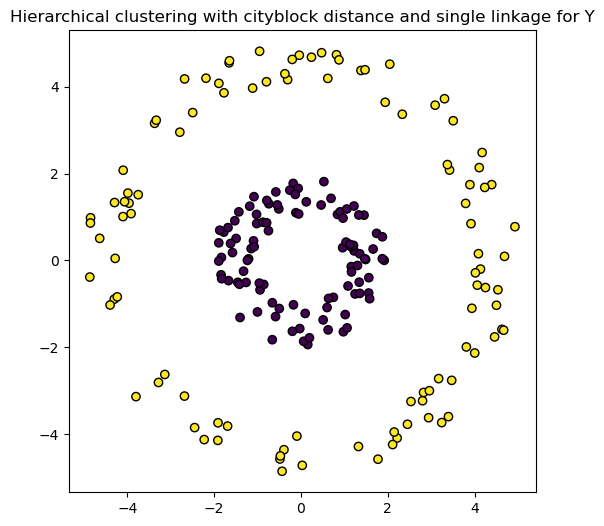

In [31]:
hierarchical_clustering(data=Y,
                        distance_metric='cityblock',
                        linkage_method='single',
                        num_clusters=2,
                        data_label='Y')

<h3>Spectral clustering</h3>

In [57]:
def spectral_clustering(data, n_clusters, affinity, data_label, n_neighbors=None, rs=None):
    sc = SpectralClustering(n_clusters=n_clusters, 
                            affinity=affinity, 
                            n_neighbors=n_neighbors)
    clusters = sc.fit_predict(data)
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(data[:, 0], data[:, 1], c=clusters, edgecolors='black')
    assert affinity.lower() in ['nearest_neighbors', 'rbf']
    if affinity.lower() == 'nearest_neighbors':
        plt.title(f'Spectral clustering for {data_label} using k-nearest neighbors')
    elif affinity.lower() == 'rbf':
        plt.title(f'Spectral clustering for {data_label} using a radial basis function')

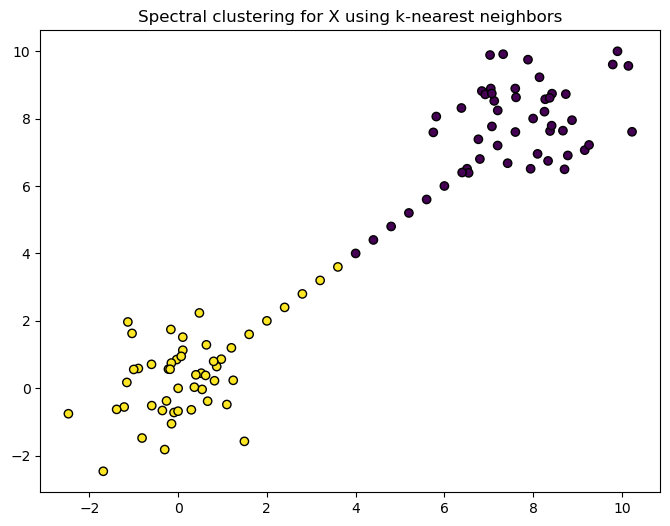

In [58]:
spectral_clustering(data=X,
                    n_clusters=2,
                    affinity='nearest_neighbors',
                    data_label='X',
                    n_neighbors=10)

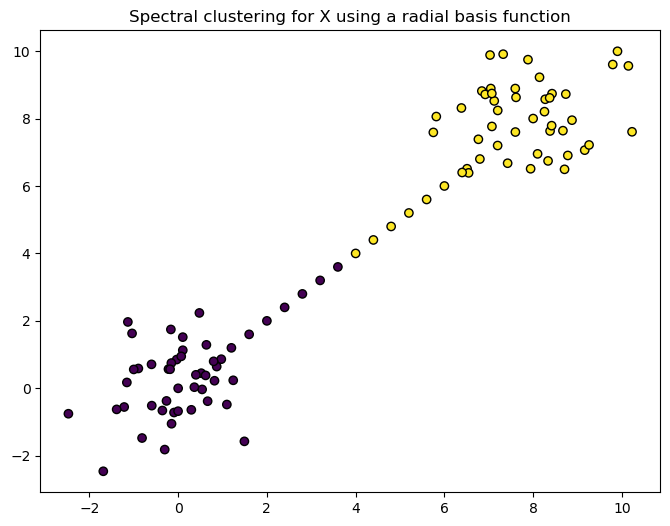

In [59]:
spectral_clustering(data=X,
                    n_clusters=2,
                    affinity='rbf',
                    data_label='X',
                    n_neighbors=10)

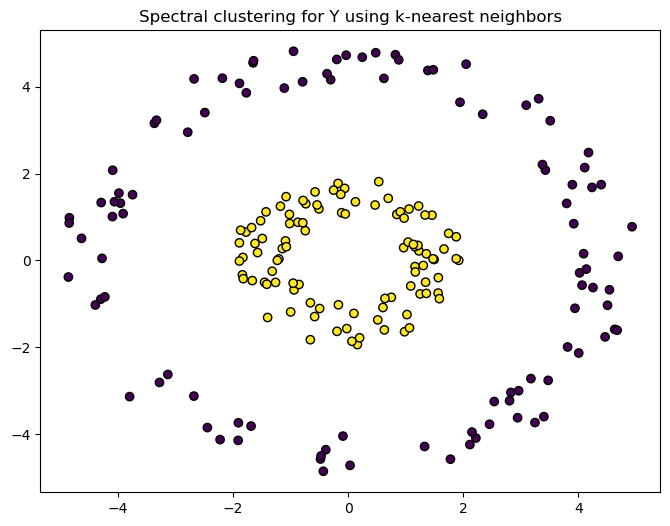

In [60]:
spectral_clustering(data=Y,
                    n_clusters=2,
                    affinity='nearest_neighbors',
                    data_label='Y',
                    n_neighbors=10)

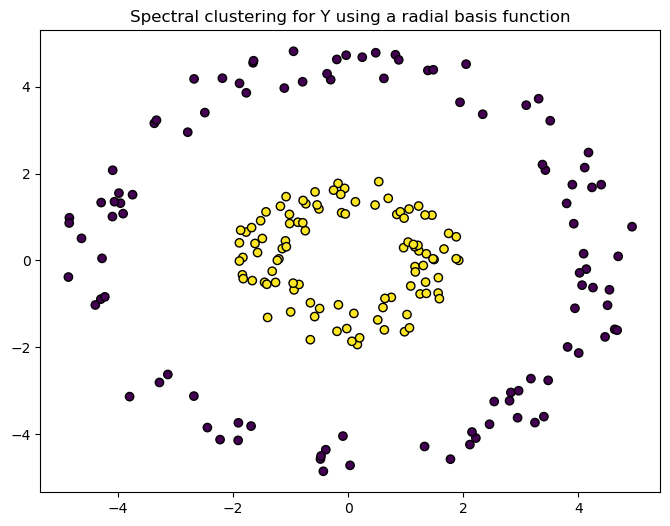

In [61]:
spectral_clustering(data=Y,
                    n_clusters=2,
                    affinity='rbf',
                    data_label='Y',
                    n_neighbors=10)

<br>

**K-means**

- Assigns points to the nearest cluster center by minimizing the sum of squared distances between points and their respective cluster centroids.
- Cannot handle non-linear data well (K-means clustering produces a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram), which consists of linear decision boundaries (Euclidean distance))
- Assumes that the variance of the distribution for each feature is spherical (i.e., that the data points are distributed symmetrically around the centroid in all directions), and that each feature have approximately equal number of samples.

**Hierarchical clustering**

- Result varies heavily based on the used linkage algorithm.

**Spectral clustering**

- Uses eigenvalues of the similarity matrix (graph representation of the data) to reduce dimensionality before clustering.
- Is able to capture non-linear structures in the data.
- Suitable for complex and non-linear data.

<h3>Task 4</h3>

In [2]:
def matrix_of_similarities(n):
    """
    Construct the similarity matrix.
    """
    s = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i == j:
                s[i,j] = 9
            elif 1 <= np.abs(i - j) <= 3:
                s[i,j] = 8
            elif 4 <= np.abs(i - j) <= 6:
                s[i,j] = 7
            elif 7 <= np.abs(i - j) <= 9:
                s[i,j] = 6
            elif 10 <= np.abs(i - j) <= 12:
                s[i,j] = 5
            elif 13 <= np.abs(i - j) <= 15:
                s[i,j] = 4
            elif 16 <= np.abs(i - j) <= 18:
                s[i,j] = 3
            elif 19 <= np.abs(i - j) <= 21:
                s[i,j] = 2
            elif 22 <= np.abs(i - j) <= 24:
                s[i,j] = 1
            elif np.abs(i - j) >= 25:
                s[i,j] = 0
    return s

In [3]:
def similarities_to_distances(n):
    D = 9 - matrix_of_similarities(n)
    return D

In [4]:
D = similarities_to_distances(n=51)

In [5]:
D.shape

(51, 51)

In [6]:
# Eigenvalues
eigenvals, eigenvecs = np.linalg.eig(D)

In [7]:
np.sort(np.round(eigenvals))[::-1]

array([ 275.,    2.,    2.,    1.,    1.,   -0.,    0.,   -0.,   -0.,
         -0.,   -0.,   -0.,    0.,   -0.,   -0.,   -0.,   -0.,   -0.,
         -0.,   -0.,   -0.,    0.,    0.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,
         -1.,   -1.,   -2.,   -3.,   -3.,   -3.,   -3.,   -5.,   -7.,
         -7.,   -8.,   -8.,  -18.,  -69., -126.])

In [12]:
def multidimensional_scaling(distances, n_dims, rs=None):
    """
    Args:
    n_dims -- the dimension of the new (transformed) space
    """
    ##### Fitting #####
    mds = MDS(n_components=n_dims, dissimilarity='precomputed')
    mds_coords = mds.fit_transform(distances)
    
    ##### Plotting #####
    plt.figure(figsize=(10,8), dpi=100)
    plt.scatter(mds_coords[:,0], mds_coords[:,1], facecolors='none', edgecolors='black')
    plt.gca().set_aspect('equal', adjustable='box')
    
    return mds_coords

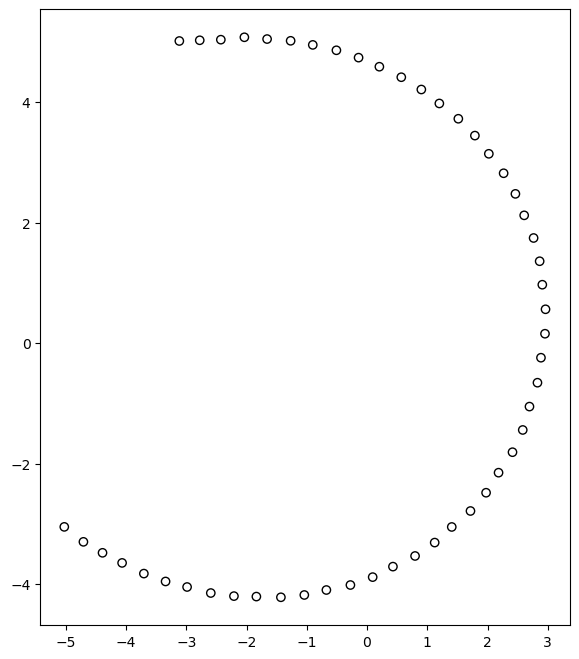

In [15]:
mds_coords = multidimensional_scaling(D, 2)

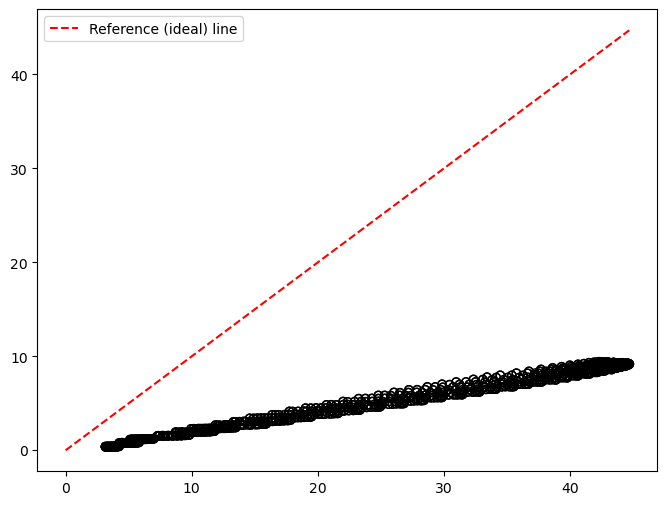

In [105]:
plt.figure(figsize=(8,6), dpi=100)
plt.scatter(pdist(D), pdist(mds_coords), facecolors='none', edgecolors='black')
plt.plot([0, np.max(pdist(D))], [0, np.max(pdist(D))], 'r--', label='Reference (ideal) line')
plt.legend();

<h3>Task 5</h3>

In [2]:
emotions = pd.read_csv("/Users/herrakaava/Documents/school/monimuuttujamenetelmat/week_4/msq.csv", index_col=0)

In [3]:
emotions.head()

,active,afraid,alert,angry,anxious,aroused,ashamed,astonished,at.ease,at.rest,...,Sociability,Impulsivity,MSQ_Round,ID,condition,MSQ_Time,TOD,TOD24,scale,exper
1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,3.0,4.0,15.0,193.0,2,15.30,15.00,NaN,r,Rim.1
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,11.0,6.0,15.0,130.0,2,15.30,15.00,NaN,r,Rim.2
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,8.0,5.0,15.0,2135.0,2,15.30,15.00,NaN,r,Rim.2
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,...,12.0,7.0,NaN,18.0,2,NaN,NaN,NaN,r,COPE
5,2.0,0.0,1.0,0.0,NaN,2.0,0.0,3.0,3.0,1.0,...,5.0,7.0,6.0,2.0,5,5.75,5.83,5.5,msq,rob-1


In [4]:
emotions.shape

(3896, 92)

In [5]:
# The number of columns with missing values
emotions.isna().any().sum()

np.int64(88)

In [6]:
emotions = emotions.iloc[:, :72]

In [7]:
emotions = emotions.dropna()

In [8]:
emotions.isna().any().any()

np.False_

In [124]:
def classical_mds(data):
    # Calculate the (squared) distances between the features (columns) 
    # using cityblock (Manhattan) 
    D = squareform(pdist(data.T, metric='cityblock'))
    
    # Multidimensional scaling
    mds = MDS(n_components=data.T.shape[0], dissimilarity='precomputed', random_state=0)
    mds_coords = mds.fit_transform(D)
    
    ###### Eigenvalues #####
    n = D.shape[0]
    H = np.identity(n) - (1/n) * np.ones((n,n))     # Centering matrix
    
    # Double centering the squared distance matrix
    K = (-1/2) * H @ D**2 @ H
    
    # 10 largest eigenvalues
    eigenvals, _ = np.linalg.eig(K)
    ten_lrgst_eigvals = np.sort(eigenvals)[::-1][:10]
    
    ###### Bar plot #####
    plt.figure(figsize=(8,6))
    sns.barplot(ten_lrgst_eigvals, color='b');
    
    ###### Scatter plot #####
    plt.figure(figsize=(12,10), dpi=150)
    plt.scatter(mds_coords[:,0], mds_coords[:,1], facecolors='none', edgecolors='black')
    
    # Add labels to the data points
    for i, label in enumerate(data.columns):
        plt.text(x=mds_coords[i,0], y=mds_coords[i,1], s=label, fontsize=9)
    
    return ten_lrgst_eigvals

array([42510903.08050433, 25786558.38842927,  4482206.1257487 ,
        3641029.35791795,  1829932.49360234,  1594274.46590265,
        1339187.92517954,  1196168.82440438,   968868.57990373,
         840964.55432989])

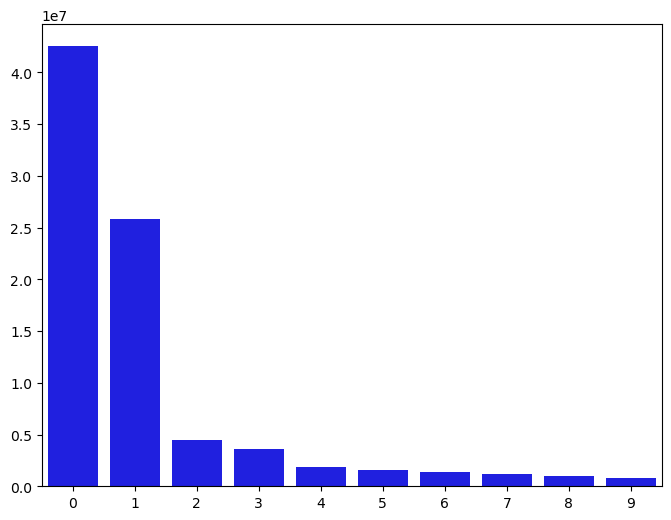

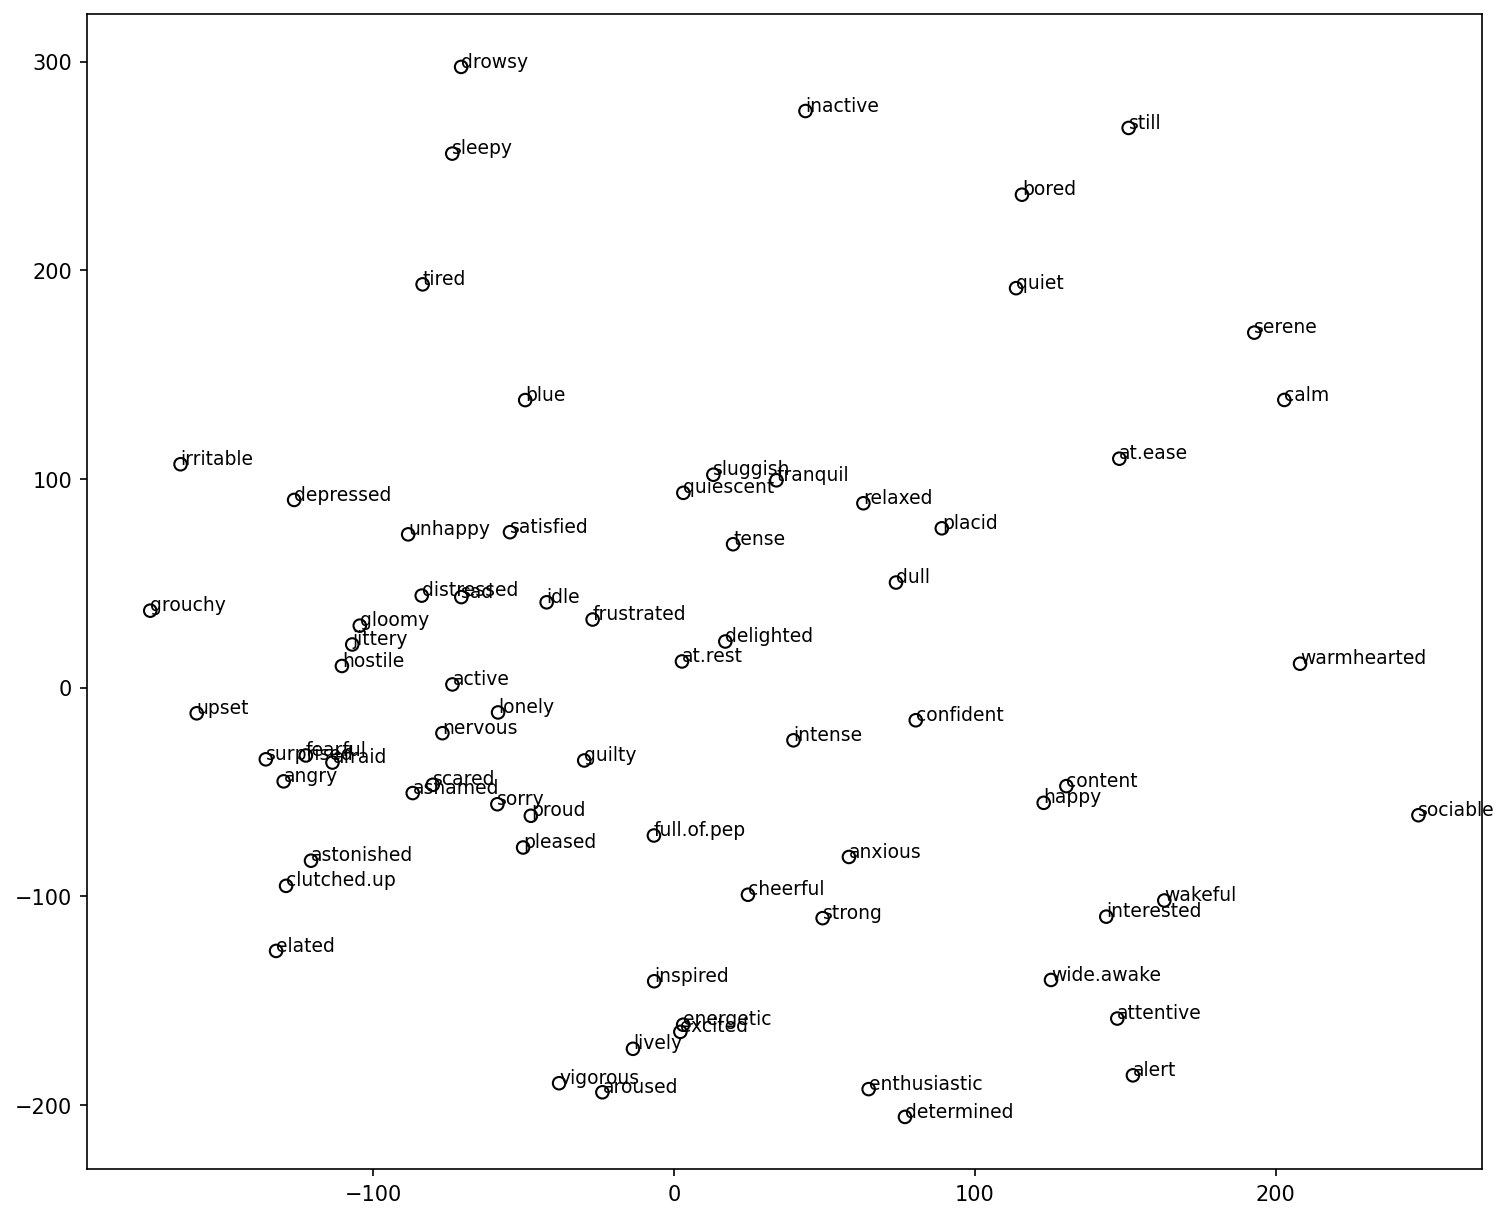

In [125]:
classical_mds(emotions)